## 2. Veri Temizleme, Dönüştürme ve Makine Öğrenmesi Modelleri

**Dataset:** <https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset>
**Github Repo:** <https://github.com/mertgenc0/hr_analytics_project>

# İnsan Kaynakları Çalışan Kaybı Tahmin Projesi

## Proje Özeti
Bu projede, çalışanların şirketten ayrılma olasılığını tahmin etmek için makine öğrenmesi algoritmaları kullanılmıştır.

### Proje Hedefleri:
- Çalışan kaybı riskini önceden belirlemek
- En etkili özellikleri tespit etmek
- En başarılı tahmin modelini seçmek

### Kullanılan Veri Seti:
- **Kaynak:** HR-Employee-Attrition.csv
- **Özellik Sayısı:** 35
- **Örnek Sayısı:** 1470
- **Hedef Değişken:** Attrition (Evet/Hayır)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
import joblib

warnings.filterwarnings('ignore')

## 2.1 Veri Setini Yükleme

In [27]:
df = pd.read_csv('HR-Employee-Attrition.csv')
df_original = df.copy()

## 2.2 Veri Temizleme ve Ön İşleme

### Yapılan İşlemler:
1. **Sabit Sütunların Kaldırılması**
   - Tüm değerleri aynı olan sütunlar çıkarıldı
   
2. **Kategorik Değişkenlerin Dönüştürülmesi**
   - İkili kategoriler: 0-1 encoding
   - Çoklu kategoriler: One-Hot Encoding
   
3. **Özellik Mühendisliği**
   - Yaş grupları oluşturuldu
   - Gelir seviyeleri kategorize edildi
   - Deneyim oranı hesaplandı

In [28]:
# sabit sütunları kaldır
constant_cols = []

for col in df.columns:
    if df[col].nunique() == 1:
        constant_cols.append(col)
df = df.drop(columns=constant_cols)

# EmployeeNumber varsa kaldır
if 'EmployeeNumber' in df.columns:
    df = df.drop(columns=['EmployeeNumber'])

#Hedef değişken encode eder
#df = df.dropna(subset=['Attrition'])  # null değer varsa siler
df['Attrition'] = df['Attrition'].map({'Yes':1,'No':0}) 


# iki farklı kategori içeren object tipindeki sütunları bulup 0-1 ile değiştiri.
binary_cols = []
for col in df.select_dtypes(include='object'):
    if df[col].nunique() == 2:
        binary_cols.append(col)
        vals = df[col].unique()
        df[col] = df[col].map({vals[0]: 0, vals[1]: 1})

# 3 veya daha fazla kategori içeren sütunları One-Hot Encoding yöntemiyle sayılsa hale çevirme 
multi_cat_cols = ['BusinessTravel', 'Department', 'MaritalStatus']
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

# Özellik mühendisliği
df['AgeGroup'] = pd.cut(df['Age'], bins=[0,30,40,50,100], labels=['Genç','Orta','Olgun','Kıdemli'])
df = pd.get_dummies(df, columns=['AgeGroup'], drop_first=True)

df['IncomeLevel'] = pd.cut(df['MonthlyIncome'], bins=[0,5000,10000,20000], labels=['Düşük','Orta','Yüksek'])
df = pd.get_dummies(df, columns=['IncomeLevel'], drop_first=True)

df['ExperienceRatio'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 1)
df['YearsSincePromotion'] = df['YearsAtCompany'] - df['YearsSinceLastPromotion']
df['AvgTrainingPerLevel'] = df['TrainingTimesLastYear'] / (df['JobLevel'] + 1)

# boolean sütunlar varsa 0/1 dönüştür
bool_cols = df.select_dtypes(include='bool').columns
for col in bool_cols:
    df[col] = df[col].astype(int)
#düzenlenmiş hali kaydedilmesi
df.to_csv('hr_processed.csv', index=False)
#df.head()

In [29]:
#df.info()

## 2.3 Train-Test Split ve Ölçeklendirme

In [37]:
#df.head()

### Train-Test Ayrımı:
- **Eğitim Seti:** %80
- **Test Seti:** %20
- **Strateji:** Stratified sampling (sınıf dengesini koruma)

### Özellik Ölçeklendirme:
- **Yöntem:** StandardScaler
- **Neden:** Farklı ölçeklerdeki özellikleri normalleştirmek

In [31]:
# Gereksiz etkisi düşük columnsları çıakrıyoruz 
drop_cols = [
    'DailyRate', 'HourlyRate', 'MonthlyRate','TrainingTimesLastYear', 'WorkLifeBalance', 'RelationshipSatisfaction','EducationField','JobRole'
]
X = df.drop(columns=drop_cols + ['Attrition'])
y = df['Attrition'] # Hedef Değişken
#X.head()
#y.head()

In [32]:
print(f"Colum: {X.shape[1]}")
print(f"roe: {X.shape[0]}")
print(f"Hedef değişken dağılımı:\n{y.value_counts()}")

# Train-Test split (stratify: sınıf dağılımını train ve test için koruması)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nEğitim seti: {X_train.shape}")
print(f"Test seti: {X_test.shape}")

# eğitim ve test verileirin standardscaler ile ölceklendirilmesi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#kaydediyoruz
joblib.dump(scaler, 'scaler.pkl')

Colum: 33
roe: 1470
Hedef değişken dağılımı:
Attrition
0    1233
1     237
Name: count, dtype: int64

Eğitim seti: (1176, 33)
Test seti: (294, 33)


['scaler.pkl']

## 2.4 SMOTE ile Dengesiz Veriyi Dengeleme


### Problem:
Veri setinde **dengesizlik** var:
- Ayrılan çalışan: %16
- Kalan çalışan: %84

### Çözüm: SMOTE (Synthetic Minority Over-sampling)
- Azınlık sınıfı için sentetik örnekler oluşturuldu
- Dengeli bir eğitim seti elde edildi

In [33]:
print(f"Önceki dağılım:\n{pd.Series(y_train).value_counts()}")

#SMOTE ile azınlık sınıf için senttetik örneler üreterek eğitim verisini dengelenmesi sağlanr
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nsonraki dağılım:\n{pd.Series(y_train_balanced).value_counts()}")

Önceki dağılım:
Attrition
0    986
1    190
Name: count, dtype: int64

sonraki dağılım:
Attrition
0    986
1    986
Name: count, dtype: int64


## 2.5 Model Eğitimi ve Karşılaştırma


### Kullanılan Algoritmalar:
1. **Logistic Regression** 
2. **Random Forest** 
3. **XGBoost** 
4. **SVM (Support Vector Machine)**

### Değerlendirme Metrikleri:
- **Accuracy:** Genel doğruluk oranı
- **F1-Score:** Precision ve recall'un harmonik ortalaması
- **ROC-AUC:** Model ayırt etme gücü
- **Cross Validation:** Model genelleme yeteneği

In [34]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    #'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    #'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    #'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'SVM': SVC(random_state=42, probability=True)
}
#sonuçları saklamak için boş liste
results = []
# Her bir modelin eğitimi ve testi
for name, model in models.items():    
    # Modeli eğtme
    model.fit(X_train_balanced, y_train_balanced)
    # Test verisi üzerinde tahmileme
    y_pred = model.predict(X_test_scaled)                 # sınıf tahminleri
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # olasılık tahmini (ROC-AUC için)

    # Başarı metriklerini hesapla
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross Validation
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='f1')

    # sonuçlar results listesine eklenemsi.
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV F1 Mean': cv_scores.mean(),
        'CV F1 Std': cv_scores.std()
    })
    
    # Modeli .pkl formatında kaydetdetme
    joblib.dump(model, f'models/{name.lower().replace(" ", "_")}_model.pkl')


In [38]:
# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False) #f1-score büyüklüğüne göre sıralama.

#Model karşılaştırma tablosu 
print(results_df.to_string(index=False))

# En iyi modeli bul
best_model_name = results_df.iloc[0]['Model']
print(f"best mdoel: {best_model_name}")

              Model  Accuracy  F1-Score  ROC-AUC  CV F1 Mean  CV F1 Std
Logistic Regression  0.823129  0.587302 0.847877    0.790514   0.023769
                SVM  0.843537  0.500000 0.771126    0.916072   0.025899
            XGBoost  0.846939  0.430380 0.808252    0.866578   0.206816
      Random Forest  0.843537  0.361111 0.814497    0.924586   0.101349
best mdoel: Logistic Regression


## 2.6 Model Karşılaştırma

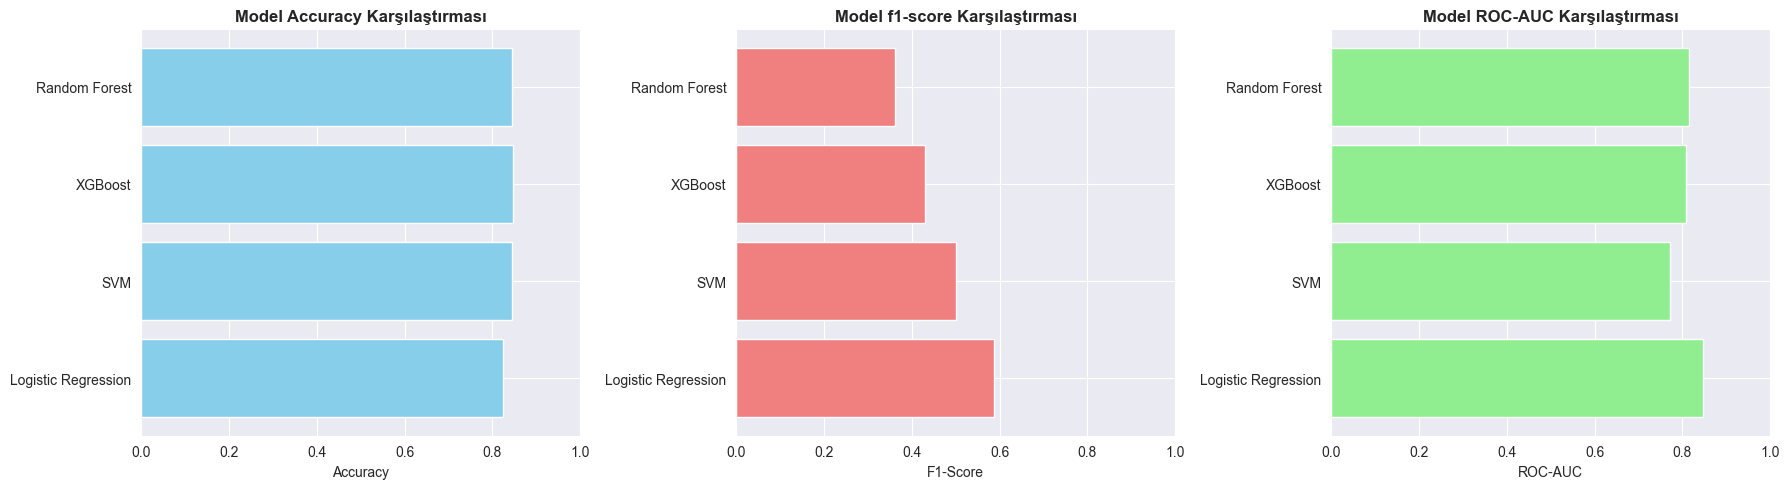

In [39]:
# karşılaştırma grafikleri
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy karşılaştırması
axes[0].barh(results_df['Model'], results_df['Accuracy'], color='skyblue')
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Karşılaştırması', fontweight='bold')
axes[0].set_xlim([0, 1])

# F1-Score karşılaştırması
axes[1].barh(results_df['Model'], results_df['F1-Score'], color='lightcoral')
axes[1].set_xlabel('F1-Score')
axes[1].set_title('Model f1-score Karşılaştırması', fontweight='bold')
axes[1].set_xlim([0, 1])

# ROC-AUC karşılaştırması
axes[2].barh(results_df['Model'], results_df['ROC-AUC'], color='lightgreen')
axes[2].set_xlabel('ROC-AUC')
axes[2].set_title('Model ROC-AUC Karşılaştırması', fontweight='bold')
axes[2].set_xlim([0, 1])

plt.tight_layout()
plt.show()

### Sonuçlar:

**En İyi Model:** Logistic Regression

- En yüksek F1-Score
- Güvenilir tahminler

### Model Seçim Kriterleri:
- F1-Score öncelikli (dengesiz veri için önemli)
- Cross validation performansı
- Genelleme yeteneği


**Yorum:** Model karşılaştırmalarında en kritik ölçüt olan F1-Score açısından Logistic Regression modeli en iyi performansı göstermiştir (0.587). Ayrıca ROC-AUC değerinin de en yüksek model olması (0.848) bu modeli genel performans açısından da öne çıkarmaktadır. Diğer modellerin cross-validation skorları yüksek olsa da test setinde düşük F1 üretmeleri overfitting işaretidir. Bu nedenle en iyi genel performansı Logistic Regression sağlamıştır.

## 2.7 En İyi Model Detaylı Analizi

In [41]:
# En iyi modeli yükle
best_model = joblib.load(f'models/{best_model_name.lower().replace(" ", "_")}_model.pkl')

# Tahminler
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Attrition', 'Attrition']))


 Classification Report:
              precision    recall  f1-score   support

No Attrition       0.95      0.83      0.89       247
   Attrition       0.47      0.79      0.59        47

    accuracy                           0.82       294
   macro avg       0.71      0.81      0.74       294
weighted avg       0.88      0.82      0.84       294


### Confusion Matrix
Model'in gerçek ve tahmin edilen değerleri karşılaştırılması:
- **True Positive (TP):** Doğru ayrılma tahmini
- **True Negative (TN):** Doğru kalma tahmini
- **False Positive (FP):** Yanlış ayrılma tahmini
- **False Negative (FN):** Kaçırılan ayrılma

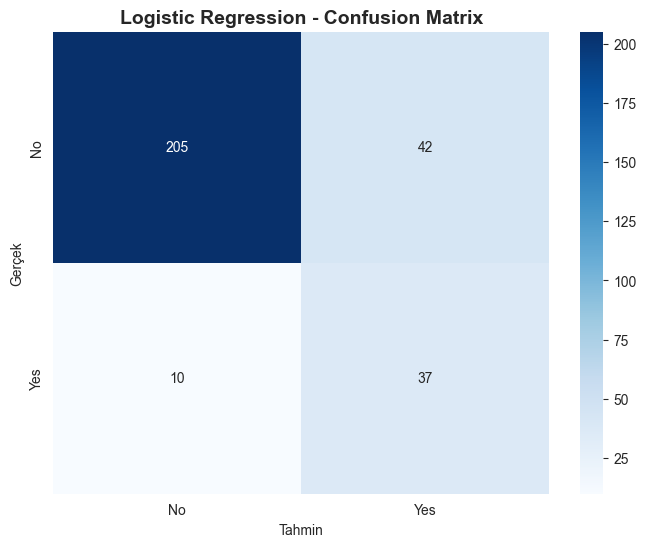

In [42]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title(f'{best_model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

### ROC Curve (Receiver Operating Characteristic)
Model'in farklı eşik değerlerindeki performansını gösterir:
- **AUC (Area Under Curve):** Model kalitesi göstergesi
- Yüksek AUC = İyi ayırt etme gücü

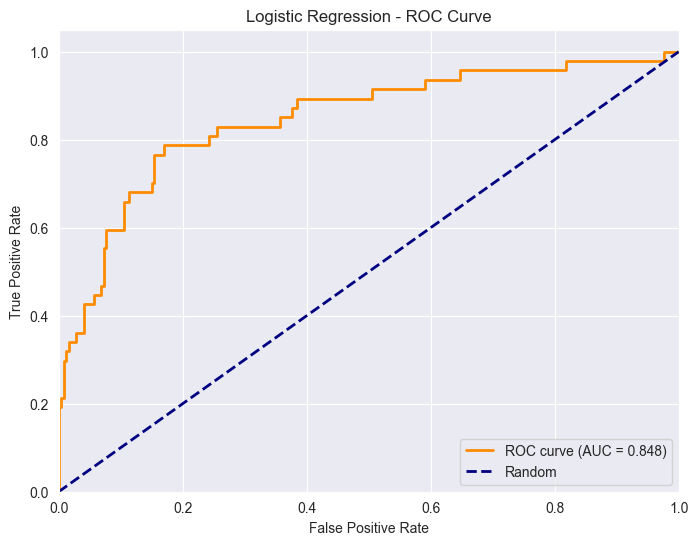

In [43]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{best_model_name} - ROC Curve')
plt.legend(loc="lower right")
plt.show()



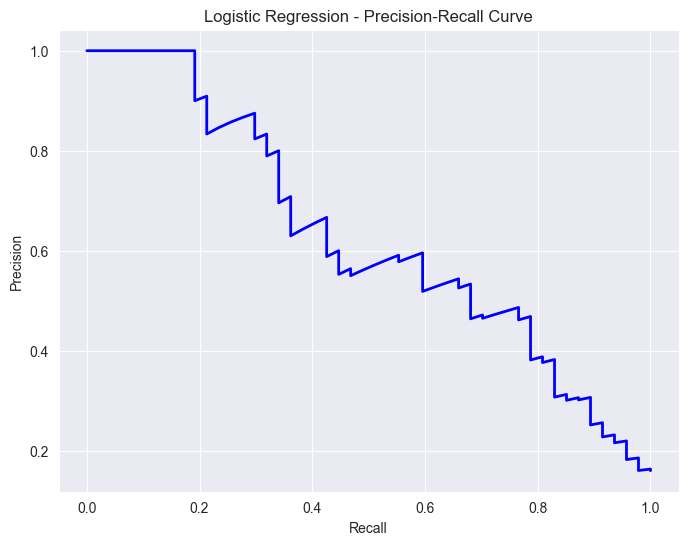

In [44]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{best_model_name} - Precision-Recall Curve')
plt.show()

## Sonuç ve Öneriler

### Proje Bulguları:
1. **En Başarılı Model:** Logistic Regression
   - F1-Score: 0.59
   - ROC-AUC: 0.85
   
2. **Önemli Özellikler:**
   - Fazla mesai durumu
   - İş tatmini
   - Şirketteki çalışma süresi
   - Aylık gelir
   
3. **Model Performansı:**
   - %82 genel doğruluk
   - Dengesiz veri setinde başarılı
   
### İş Önerileri:
- Fazla mesai yapan çalışanlara özel dikkat
- Düşük iş tatminli çalışanlarla görüşme
- İlk yıl çalışanlara mentorluk programı
- Maaş adaleti analizi
